# Benchmark dynamic circuts with cut Bell pairs

*Estimated QPU usage: 22 seconds (tested on IBM Kingston)*

## Background

Quantum hardware is typically limited to local interactions, but many algorithms require entangling distant qubits or even [qubits on separate processors](#references). Dynamic circuits, that is circuits with mid-circuit measurement and feedforward, provide a way to overcome these limitations by using real-time classical communication to effectively implement non-local quantum operations. In this approach, measurement outcomes from one part of a circuit (or one QPU) can conditionally trigger gates on another, allowing us to teleport entanglement across long distances. This forms the basis of **Local Operations and Classical Communication (LOCC)** schemes, where we consume entangled resource states (Bell pairs) and communicate measurement results classically to link far-apart qubits.

One promising use of LOCC is to realize virtual long-range CNOT gates by teleportation as shown in the [long-range entanglement tutorial](https://quantum.cloud.ibm.com/docs/en/tutorials/long-range-entanglement). Instead of a direct long-range CNOT (which hardware connectivity may not permit), we create Bell pairs and perform a teleportation-based gate implementation. However, the fidelity of such operations depends on hardware characteristics. Qubit decoherence during the necessary delay (while waiting for measurement results) and classical communication latency can degrade the entangled state. Also, errors on mid-circuit measurements are harder to correct than errors on final measurements as they propagate to the rest of the circuit through the conditional gates.

In the [reference experiment](#references), the authors introduce a Bell pair fidelity benchmark to identify which parts of a device are best suited for LOCC-based entanglement. The idea is to run a small dynamic circuit on every group of four connected qubits in the processor. This four-qubit circuit first creates a Bell pair on two middle qubits, then uses those as a resource to entangle the two edge qubits via LOCC. Concretely, qubits 1 and 2 are prepared into an uncut Bell pair locally (using a Hadamard and CNOT), and then a teleportation routine consumes that Bell pair to entangle qubits 0 and 3. Qubits 1 and 2 are measured during execution of the circuit, and based on those outcomes, Pauli corrections (an X on qubit 3 and Z on qubit 0) are applied. Qubits 0 and 3 are then left in a Bell state at the end of the circuit.

To quantify the quality of this final entangled pair, we measure its stabilizers: specifically the parity in the $Z$ basis ($Z_0Z_3$) and in the $X$ basis ($X_0X_3$). For a perfect Bell pair, both of these expectations equal +1. In practice, hardware noise will reduce these values. We therefore repeat the circuit twice for each qubit-pair: one circuit measures qubits 0 and 3 in the $Z$ basis, and another measures them in the $X$ basis. From the results, we obtain an estimate of $\langle Z_0Z_3\rangle$ and $\langle X_0X_3\rangle$ for that pair of qubits. We use the mean squared error (MSE) of these stabilizers with respect to the ideal value 1 as a simple metric of entanglement fidelity. A lower MSE means the two qubits achieved a Bell state closer to ideal (higher fidelity), whereas a higher MSE indicates more error. By scanning this experiment across the device, we can benchmark the measurement-and-feedforward capability of different qubit groups and identify the best pairs of qubits for LOCC operations.

This tutorial demonstrates the experiment on an IBM Quantum device to illustrate how dynamic circuits can be used to generate and evaluate entanglement between distant qubits. We will map out all 4-qubit linear chains on the device, run the teleportation circuit on each, and then visualize the distribution of MSE values. This end-to-end procedure shows how to leverage Qiskit Runtime and dynamic circuit features to inform hardware-aware choices for cutting circuits or distributing quantum algorithms across a modular system.



## Requirements

Before starting this tutorial, ensure that you have the following installed:

* Qiskit SDK 1.0 or later, with visualization support (`pip install 'qiskit[visualization]'`)
* Qiskit Runtime 0.22 or later (`pip install qiskit-ibm-runtime`)


## Setup

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit import IfElseOp 

from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.transpiler import generate_preset_pass_manager

import numpy as np
import matplotlib.pyplot as plt

def create_bell_stab(initial_layouts):
    """
    Create a circuit for a 1D chain of qubits (number of qubits must be a multiple of 4), 
    where a middle Bell pair is consumed to create a Bell at the edge.  
    Takes as input a list of lists, where each element of the list is a 
    1D chain of physical qubits that is used as the initial_layout for the transpiled circuit.
    Returns a list of length-2 tuples, each tuple contains a circuit to measure the ZZ stabilizer and 
    a circuit to measure the XX stabilizer of the edge Bell state.
    """
    bell_circuits = []
    for initial_layout in initial_layouts: # Iterate over chains of physical qubits
        assert len(initial_layout)%4 == 0, f'The length of the chain must be a multiple of 4, len(inital_layout)={len(initial_layout)}'
        num_pairs = len(initial_layout)//4

        bell_parallel =  QuantumCircuit(4*num_pairs, 4*num_pairs)

        for pair_idx in range(num_pairs):


            (q0, q1, q2, q3) = pair_idx*4, pair_idx*4+1, pair_idx*4+2, pair_idx*4+3
            (c0, c1) = pair_idx*4, pair_idx*4+3 # edge qubits
            (ca0, ca1) = pair_idx*4+1, pair_idx*4+2 # middle qubits

            bell_parallel.h(q0)
            bell_parallel.h(q1)
            bell_parallel.cx(q1,q2)
            bell_parallel.cx(q0,q1)
            bell_parallel.cx(q2,q3)
            bell_parallel.h(q2)
            
        #add barrier BEFORE measurements and add id in conditional
        bell_parallel.barrier()
        for pair_idx in range(num_pairs):
            (q0, q1, q2, q3) = pair_idx*4, pair_idx*4+1, pair_idx*4+2, pair_idx*4+3
            (ca0, ca1) = pair_idx*4+1, pair_idx*4+2 # middle qubits

            bell_parallel.measure(q1,ca0)
            bell_parallel.measure(q2,ca1)
        #bell_parallel.barrier() #remove barrier after measurement

        for pair_idx in range(num_pairs):
            (q0, q1, q2, q3) = pair_idx*4, pair_idx*4+1, pair_idx*4+2, pair_idx*4+3
            (ca0, ca1) = pair_idx*4+1, pair_idx*4+2 # middle qubits
            with bell_parallel.if_test((ca0, 1)):
                bell_parallel.x(q3)
            with bell_parallel.if_test((ca1, 1)):
                bell_parallel.z(q0)
                bell_parallel.id(q0) #add id here for correct alignment

        bell_zz = bell_parallel.copy()
        bell_zz.barrier()
        bell_xx = bell_parallel.copy()
        bell_xx.barrier()
        for pair_idx in range(num_pairs):
            (q0, q1, q2, q3) = pair_idx*4, pair_idx*4+1, pair_idx*4+2, pair_idx*4+3
            bell_xx.h(q0)
            bell_xx.h(q3) 
        bell_xx.barrier()
        for pair_idx in range(num_pairs):
            (q0, q1, q2, q3) = pair_idx*4, pair_idx*4+1, pair_idx*4+2, pair_idx*4+3
            (c0, c1) = pair_idx*4, pair_idx*4+3 # edge qubits


            bell_zz.measure(q0,c0)
            bell_zz.measure(q3,c1)

            bell_xx.measure(q0,c0)
            bell_xx.measure(q3,c1)

        bell_circuits.append(bell_zz)
        bell_circuits.append(bell_xx)

    return bell_circuits


def get_mse(result, initial_layouts):
    """ 
    given a result object and the initial layouts, returns a dict of layouts and their mse
    """
    layout_mse = {}
    for layout_idx, initial_layout in enumerate(initial_layouts):
        layout_mse[tuple(initial_layout)] = {}
        
        num_pairs = len(initial_layout)//4

        counts_zz = result[2*layout_idx].data.c.get_counts()
        total_shots = sum(counts_zz.values())

        # Get ZZ expectation value
        exp_zz_list = []
        for pair_idx in range(num_pairs):
            exp_zz = 0
            for bitstr, shots in counts_zz.items():
                bitstr = bitstr[::-1] # reverse order to big endian
                b1, b0 = bitstr[pair_idx*4], bitstr[pair_idx*4+3] # parse bitstring to get edge measurements for each 4-q chain
                z_val0 = 1 if b0 == '0' else -1
                z_val1 = 1 if b1 == '0' else -1  
                exp_zz += z_val0 * z_val1 * shots
            exp_zz /= total_shots
            exp_zz_list.append(exp_zz)

        counts_xx = result[2*layout_idx + 1].data.c.get_counts()
        total_shots = sum(counts_xx.values())

        # Get XX expectation value
        exp_xx_list = []
        for pair_idx in range(num_pairs):
            exp_xx = 0
            for bitstr, shots in counts_xx.items():
                bitstr = bitstr[::-1] # reverse order to big endian
                b1, b0 = bitstr[pair_idx*4], bitstr[pair_idx*4+3] # parse bitstring to get edge measurements for each 4-q chain
                x_val0 = 1 if b0 == '0' else -1
                x_val1 = 1 if b1 == '0' else -1  
                exp_xx += x_val0 * x_val1 * shots
            exp_xx /= total_shots
            exp_xx_list.append(exp_xx)

        mse_list = [((exp_zz - 1)**2 + (exp_xx - 1)**2)/2 for exp_zz, exp_xx in zip(exp_zz_list, exp_xx_list)]
        
        print(f'layout {initial_layout}')
        for idx in range(num_pairs):
            layout_mse[tuple(initial_layout)][tuple(initial_layout[4*idx:4*idx+4])] = mse_list[idx]
            print(f'qubits: {initial_layout[4*idx:4*idx+4]}, mse:, {round(mse_list[idx],4)}')
            # print(f'exp_zz: {round(exp_zz_list[idx],4)}, exp_xx: {round(exp_xx_list[idx],4)}')
        print(' ')
    return layout_mse
    

def plot_mse_ecdfs(layouts_mse, combine_layouts = False):
    """
    Plot CDF of MSE data for multiple layouts. Optionally combine all data in a single CDF
    """

    if not combine_layouts:
        for initial_layout, layouts in layouts_mse.items():
            
            sorted_layouts = dict(sorted(layouts.items(), key=lambda item: item[1])) # sort layouts by mse 

            # get layouts and mses
            layout_list = list(sorted_layouts.keys())
            mse_list = np.asarray(list(sorted_layouts.values()))

            # convert to numpy
            x = np.array(mse_list)
            y = np.arange(1, len(x) + 1) / len(x)

            # Prepend (x[0], 0) to start CDF at zero
            x = np.insert(x, 0, x[0])
            y = np.insert(y, 0, 0)

            # Create the plot
            plt.plot(x, y, marker='x', linestyle='-', label = f'qubits: {initial_layout}')

            # add qubits labels for the edge pairs
            for xi, yi, q in zip(x[1:], y[1:], layout_list):
                plt.annotate([q[0], q[3]], (xi, yi), textcoords="offset points",
                            xytext=(5, -10), ha='left', fontsize=8)
    
    elif combine_layouts:
        all_layouts = {}
        all_initial_layout = []
        for initial_layout, layouts in layouts_mse.items(): # puts together all layout information
            all_layouts.update(layouts)
            all_initial_layout += initial_layout

        sorted_layouts = dict(sorted(all_layouts.items(), key=lambda item: item[1])) # sort layouts by mse 

        # get layouts and mses
        layout_list = list(sorted_layouts.keys())
        mse_list = np.asarray(list(sorted_layouts.values()))

        # convert to numpy
        x = np.array(mse_list)
        y = np.arange(1, len(x) + 1) / len(x)

        # Prepend (x[0], 0) to start CDF at zero
        x = np.insert(x, 0, x[0])
        y = np.insert(y, 0, 0)

        # Create the plot
        plt.plot(x, y, marker='x', linestyle='-', label = f'qubits: {sorted(list(set(all_initial_layout)))}')

        # add qubits labels for the edge pairs
        for xi, yi, q in zip(x[1:], y[1:], layout_list):
            plt.annotate([q[0], q[3]], (xi, yi), textcoords="offset points",
                        xytext=(5, -10), ha='left', fontsize=8)




    plt.xscale('log')
    plt.xlabel('Mean squared error of ⟨ZZ⟩ and ⟨XX⟩')
    plt.ylabel('Cumulative distribution function')
    plt.title('CDF for different initial layouts')
    plt.grid(alpha=0.3)
    plt.show()

     

## Step 1: Map classical inputs to a quantum problem

The first step is to create a set of quantum circuits to benchmark all candidate Bell-pair links tailored to the device’s topology. We programmatically search the device coupling map for all linearly connected chains of 4 qubits. Each such chain (labelled by qubit indices $[q0–q1–q2–q3]$) will serve as a test case for the entanglement-swapping circuit. By identifying all possible length-4 paths, we ensure maximum coverage for possible grouping of qubits that could realize the protocol.



In [ ]:
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False, dynamic_circuits=True)
if 'if_else' not in backend.target.operation_names:
    backend.target.add_instruction(IfElseOp, name="if_else")


We generate these chains using a helper function that performs a greedy search on the device graph. It returns “stripes” of four 4-qubit chains bundled into 16-qubit groups (dynamic circuit constraints the size of the measurement register to `16` qubits at the moment of writing). Bundling allows us to run multiple 4-qubit experiments in parallel on distinct parts of the chip and make efficient use of the whole device. Each 16-qubit stripe contains four disjoint chains, meaning no qubit is reused within that group. For example, one stripe might consist of chains $[0-1-2-3]$, $[4-5-6-7]$, $[8-9-10-11]$, and $[12-13-14-15]$ all packaged together. Any qubit that was not included in a stripe is returned in the `leftover` variable

In [79]:
from itertools import chain
from collections import defaultdict
from qiskit.providers.backend import BackendV1, BackendV2

def stripes16_from_backend(backend):
    """
    Creates stripes of 16 qubits, four non-overlapping  4-qubit chains, that cover as much of
    the coupling map as possible. Returns any unused qubits as leftovers.
    """
    #get undirected adjacency list
    edges = backend.coupling_map.get_edges()
    graph = defaultdict(set)
    for u, v in edges:
        graph[u].add(v)
        graph[v].add(u)

    qubits = sorted(graph)  # all qubit indices that appear

    # greedy search for 4-long linear chains (blocks) ────────────
    used = set() # qubits already placed in a block
    blocks = [] # each block is a 4-qubit list

    for q in qubits: # deterministic order for reproducibility
        if q in used:
            continue # already consumed by earlier block
        # depth-first "straight" walk of length 3 without revisiting nodes
        def extend(path):
            if len(path) == 4:
                return path
            tip = path[-1]
            for nbr in sorted(graph[tip]): # deterministic
                if nbr not in path and nbr not in used:
                    maybe = extend(path + [nbr])
                    if maybe:
                        return maybe
            return None

        block = extend([q])
        if block: # found a 4-node path
            blocks.append(block)
            used.update(block)

    # bundle four 4-qubit blocks into one 16-qubit stripe (max number of measurement compatible with if-else)
    stripes = [
        list(chain.from_iterable(blocks[i:i + 4]))
        for i in range(0, len(blocks) // 4 * 4, 4)   # full groups of four
    ]

    leftovers = set(qubits) - set(chain.from_iterable(stripes))
    return stripes, leftovers


In [80]:
initial_layouts ,leftover = stripes16_from_backend(backend)



Next, we construct the circuit for each 16-qubit stripe. The routine does the following for each chain:

* Prepare a middle Bell pair: Apply a Hadamard on qubit 1 and a CNOT from qubit 1 to qubit 2. This entangles qubits 1 and 2 (creating an $|\Phi^+\rangle = (|00\rangle + |11\rangle)/\sqrt{2}$ Bell state).
* Entangle to the edge qubits: Apply a CNOT from qubit 0 to qubit 1, and a CNOT from qubit 2 to qubit 3. This links the initially separate pairs so that qubits 0 and 3 will become entangled after the next steps. A Hadamard on qubit 2 is also applied (this, combined with the previous CNOTs, forms part of a Bell measurement on qubits 1 and 2). At this point, qubits 0 and 3 are not yet entangled, but qubits 1 and 2 are entangled with them in a larger four-qubit state.
* Mid-circuit measurements and feedforward: Qubits 1 and 2 (the middle qubits) are measured in the computational basis, yielding two classical bits. Based on those measurement outcomes, we apply conditional operations: if the qubit 1 measurement (call this bit $m_{12}$) is 1, we apply an $X$ gate on qubit 3; if the qubit 2 measurement ($m_{21}$) is 1, we apply a $Z$ gate on qubit 0. These conditional gates (realized using Qiskit’s `if_test`/`if_else` construct) implement the standard teleportation corrections. They “undo” the random Pauli flips that occur due to projecting qubits 1 and 2, ensuring that qubits 0 and 3 end up in a known Bell state regardless of the measurement outcomes. After this step, qubits 0 and 3 should ideally be entangled in the Bell state $|\Phi^+\rangle$.
* Measure Bell pair stabilizers: We then split into two versions of the circuit. In the first version, we  measure the $ZZ$ stabilizer on qubits 0 and 3. In the second version, we measure the $XX$ stabilizer on these qubits.

For each 4-qubit initial layout, the above function returns two circuits (one for $ZZ$, one for $XX$ stabilizer measurement). At the end of this step, we have a list of circuits covering every 4-qubit chain on the device. These circuits include mid-circuit measurements and conditional (if/else) operations, which are the key instructions of the dynamic circuit.

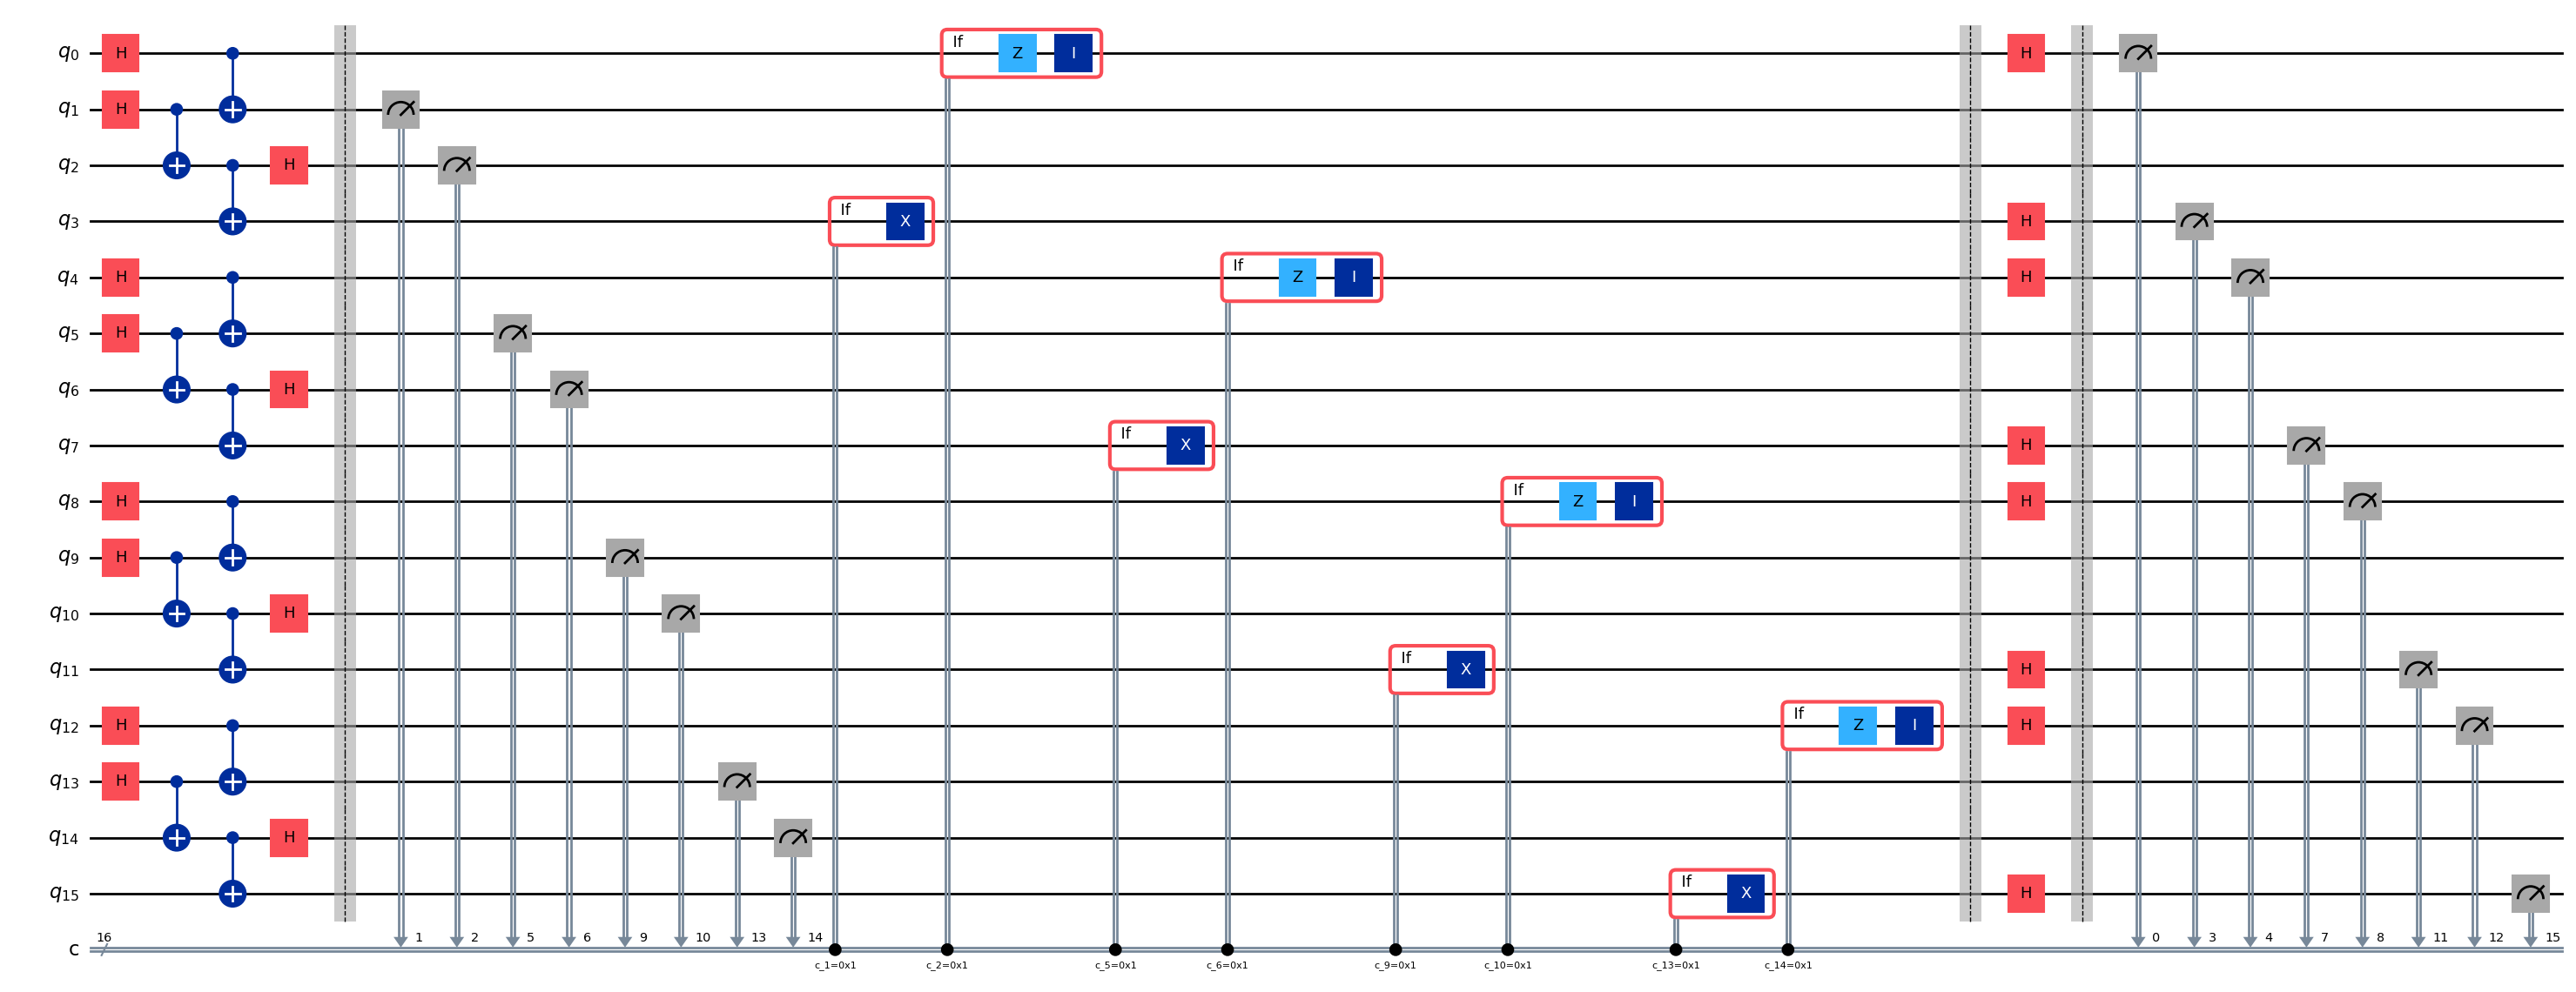

In [63]:
circuits = create_bell_stab(initial_layouts)   
circuits[-1].draw('mpl', fold=-1)

## Step 2: Optimize problem for quantum hardware execution


Before executing our circuits on real hardware, we need to transpile them to match the device’s physical constraints. Transpilation will map the abstract circuit onto the physical qubits and gate set of the chosen device. Since we have already chosen specific physical qubits for each chain (by providing an `initial_layout` to the circuit generator), we use transpiler `optimization_level=0` with that fixed layout. This tells Qiskit not to reassign qubits or perform any heavy optimizations that could alter the circuit structure. We want to keep the sequence of operations (especially the conditional gates) exactly as specified.

One important preparation is to ensure the transpiler knows about the dynamic circuit instructions. We explicitly add the `IfElseOp` (if/else construct) to the backend’s instruction set (`backend.target`) before transpiling. This lets the transpiler and scheduler know that our hardware can handle the conditional operations natively.

In [ ]:
isa_circuits=[]
for ind,init_layout in enumerate(initial_layouts):
    pm = generate_preset_pass_manager(optimization_level=0, backend=backend, initial_layout=init_layout)
    isa_circ =  pm.run(circuits[ind*2:ind*2+2])  
    isa_circuits.extend(isa_circ)

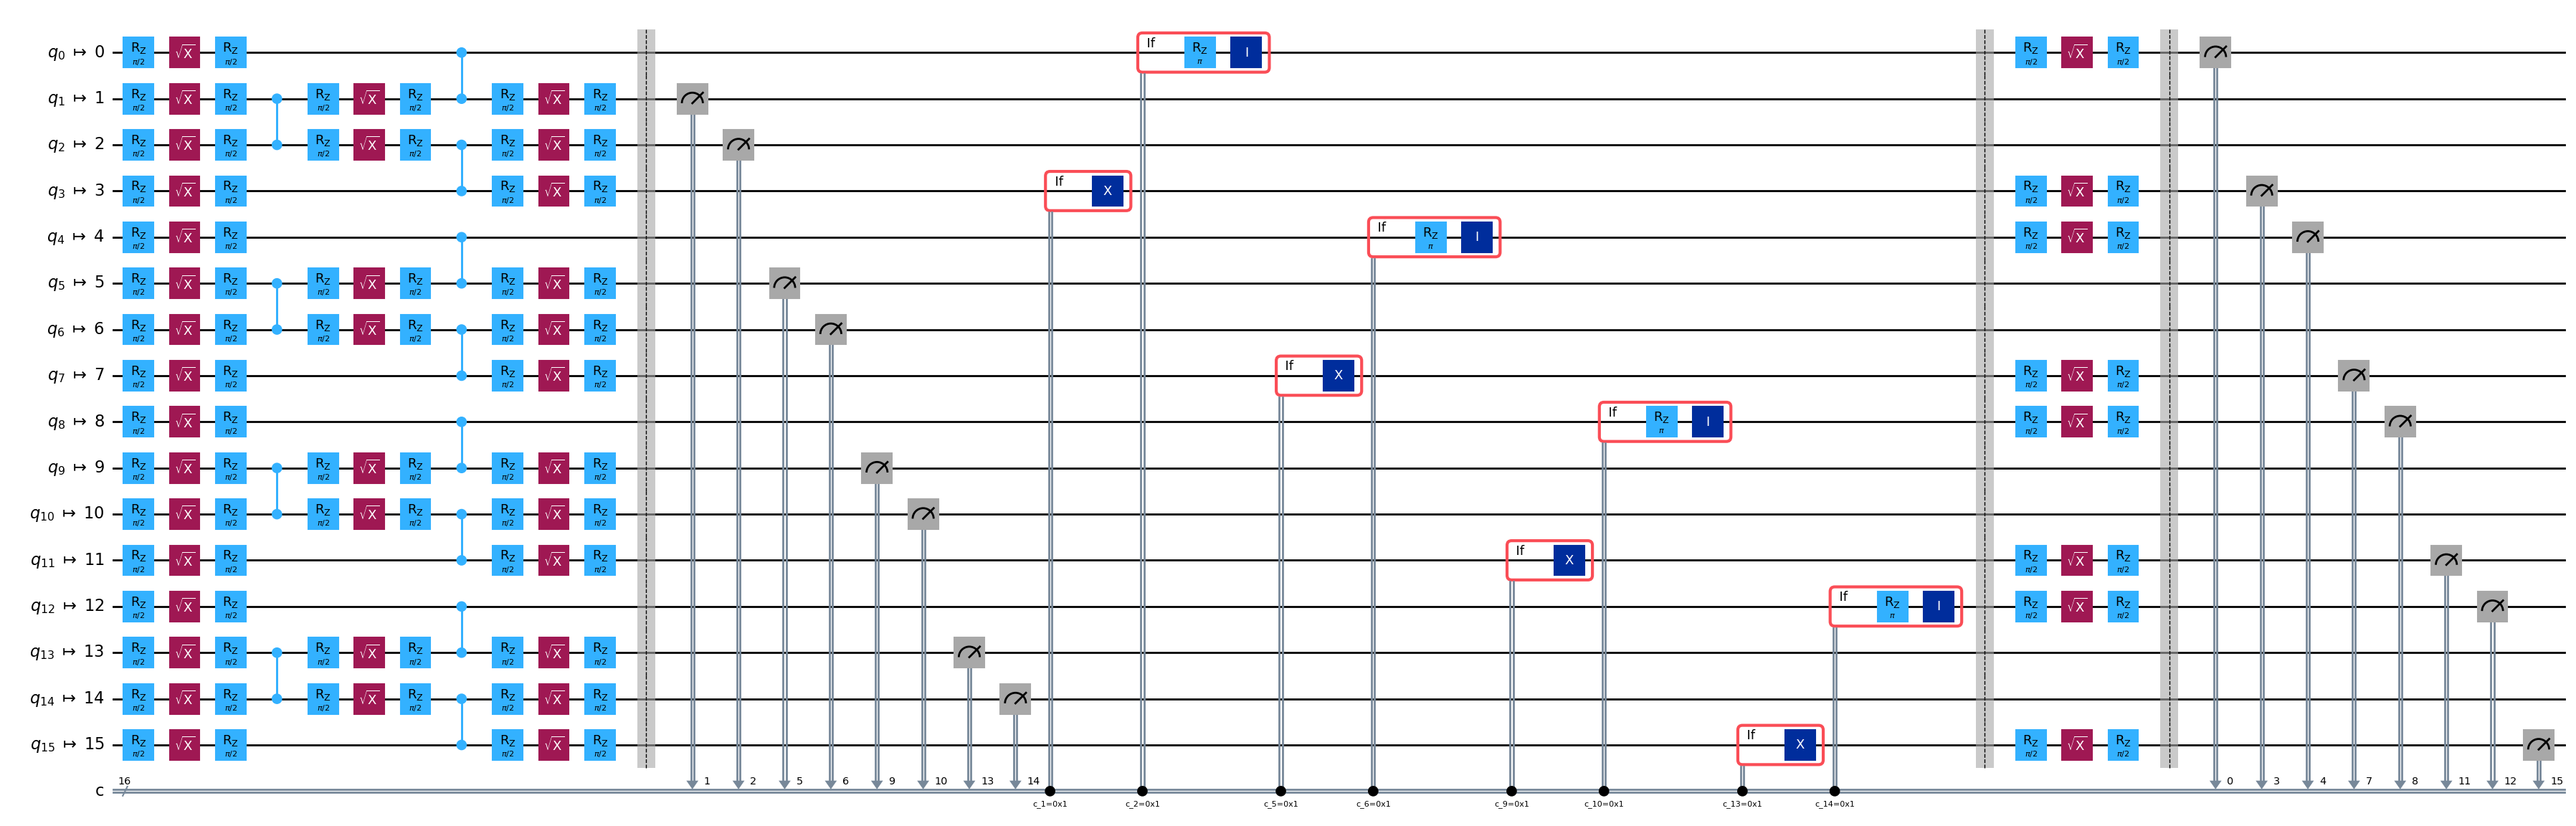

In [65]:
isa_circuits[1].draw('mpl',fold=-1, idle_wires=False)

## Step 3: Execute using Qiskit primitives


We can now run the experiment on the quantum device. We use Qiskit Runtime and its Sampler primitive to execute the batch of circuits efficiently.



In [ ]:
sampler = Sampler(mode=backend)
sampler.options.experimental= {"execution_path" : "gen3-experimental", "require_isa_circuits": False}
sampler.options.environment.job_tags = [f'cut-bell-pair-test']
job = sampler.run(isa_circuits)


## Step 4: Post-process and return result in desired classical format


The final step is to compute the mean squared error metric (MSE) for each tested qubit group and summarize the results. For each chain, we now have the measured $\langle Z_0Z_3\rangle$ and $\langle X_0X_3\rangle$. If the qubits 0 and 3 were perfectly entangled in a $|\Phi^+\rangle$ Bell state, we would expect both of these to be +1. We quantify the deviation using the MSE:

$$\text{MSE} = \frac{( \langle Z_0Z_3\rangle - 1)^2 + (\langle X_0X_3\rangle - 1)^2}{2}.$$

This value is 0 for a perfect Bell pair, and increases as the entangled state gets noisier (with random outcomes giving an expectation around 0, the MSE would approach 1). The code calculates this MSE for each 4-qubit group.

The results reveals a wide range of entanglement quality across the device. This confirms the paper’s finding that there can be over an order of magnitude variation in Bell-state fidelity depending on which physical qubits are used. In practical terms, certain regions or links in the chip are much better at doing mid-circuit measurement and feedforward operations than others. Factors like qubit readout error, qubit lifetime, and crosstalk likely contribute to these differences. For instance, if one chain includes a particularly noisy readout qubit, the mid-circuit measurement could be unreliable, leading to a poor fidelity for that entangled pair (high MSE).


In [71]:
layouts_mse = get_mse(job.result(), initial_layouts)

layout [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
qubits: [0, 1, 2, 3], mse:, 0.0312
qubits: [4, 5, 6, 7], mse:, 0.0491
qubits: [8, 9, 10, 11], mse:, 0.0711
qubits: [12, 13, 14, 15], mse:, 0.0436
 
layout [16, 23, 22, 21, 17, 27, 26, 25, 18, 31, 30, 29, 19, 35, 34, 33]
qubits: [16, 23, 22, 21], mse:, 0.0197
qubits: [17, 27, 26, 25], mse:, 0.113
qubits: [18, 31, 30, 29], mse:, 0.0287
qubits: [19, 35, 34, 33], mse:, 0.0433
 
layout [36, 41, 42, 43, 37, 45, 46, 47, 38, 49, 50, 51, 39, 53, 54, 55]
qubits: [36, 41, 42, 43], mse:, 0.1645
qubits: [37, 45, 46, 47], mse:, 0.0409
qubits: [38, 49, 50, 51], mse:, 0.0519
qubits: [39, 53, 54, 55], mse:, 0.0829
 
layout [56, 63, 62, 61, 57, 67, 66, 65, 58, 71, 70, 69, 59, 75, 74, 73]
qubits: [56, 63, 62, 61], mse:, 0.8663
qubits: [57, 67, 66, 65], mse:, 0.0375
qubits: [58, 71, 70, 69], mse:, 0.0664
qubits: [59, 75, 74, 73], mse:, 0.0291
 
layout [76, 81, 82, 83, 77, 85, 86, 87, 78, 89, 90, 91, 79, 93, 94, 95]
qubits: [76, 81, 82, 83], mse

Finally, we visualize the overall performance by plotting the cumulative distribution function (CDF) of the MSE values for all chains. The CDF plot shows on the x-axis the MSE threshold and on the y-axis the fraction of qubit pairs that have at most that MSE. This curve starts at zero and approaches 1 as the threshold grows to encompass all data points. A steep rise near low MSE would indicate many pairs are high-fidelity; a slow rise means many pairs have larger error. We annotate the CDF with the identities of the best pairs. In the plot, each point in the CDF corresponds to one 4-qubit chain’s MSE, and we label the point with the pair of qubit indices $[q0, q3]$ that were entangled in that experiment. This makes it easy to spot which physical qubit pairs are the top performers (the far-left points on the CDF).

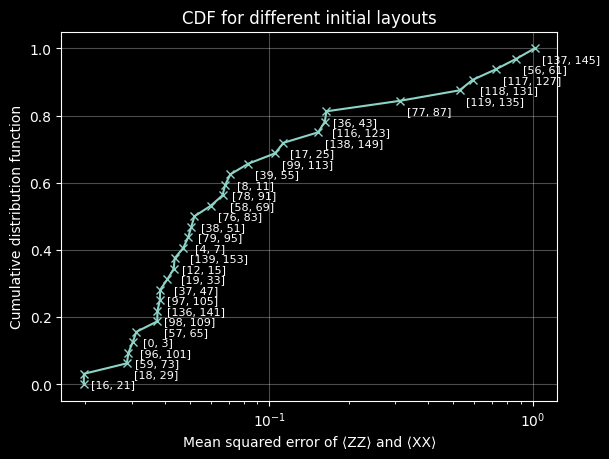

In [68]:
plot_mse_ecdfs(layouts_mse, combine_layouts=True)

## References

[\[1\]](#Reference1)[ Carrera Vazquez, A., Tornow, C., Ristè, D. et al. Combining quantum processors with real-time classical communication. Nature 636, 75–79 (2024).](https://www.nature.com/articles/s41586-024-08178-2)